# K-NN

Load the required modules

In [1]:
import numpy as np   
import pandas as pd
import matplotlib.pyplot as plt        
import sklearn
import sklearn.datasets as ds            
import sklearn.model_selection as cv   
import sklearn.neighbors as nb      
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score
from statsmodels.stats.proportion import proportion_confint
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline                     

**Index**

1. Load data <br>
2. Test accuracy <br>
    2.1. Only numerical features <br>
    2.2. Only categorical features <br>
    2.3. Numerical and categorical features <br>
    2.4. Only numerical features from PCA <br>
    2.5. Numerical features from PCA and categorical <br>
3. Some modifications <br>
    3.1. Balanced dataset <br>
    3.2. Change distance metric <br>
4. How the amount of training data influences accuracy <br>
6. Comparison table <br>
7. Best result analysis <br>

# 1. Load data

We load the training and testing dataset from disk, the first to optimize our model and the second to check the accuracy.

In [2]:
train_data = pd.read_csv('../datasets/preprocessed/train.csv', sep=',')
test_data = pd.read_csv('../datasets/preprocessed/test.csv', sep=',')
id_train_data = train_data['Id'] # useful when merging datasets in 2.5. chapter
id_test_data = test_data['Id'] # useful when merging datasets in 2.5. chapter
train_data.drop(columns=['Id'],inplace=True)
test_data.drop(columns=['Id'],inplace=True)
print('Train data size ' + str(train_data.shape))
print('Test data size ' + str(test_data.shape))

Train data size (1006, 47)
Test data size (432, 47)


In [3]:
y_train = train_data['SalePrice'].to_numpy()
y_test = test_data['SalePrice'].to_numpy()
train_data.drop(columns=['SalePrice'],inplace=True)
test_data.drop(columns=['SalePrice'],inplace=True)

In [4]:
train_pca_data = pd.read_csv('../datasets/preprocessed/train_pca.csv', sep=',')
test_pca_data = pd.read_csv('../datasets/preprocessed/test_pca.csv', sep=',')
id_train_pca_data = train_pca_data['Id'] # useful when merging datasets in 2.5. chapter
id_test_pca_data = test_pca_data['Id'] # useful when merging datasets in 2.5. chapter
train_pca_data.drop(columns=['Id'],inplace=True)
test_pca_data.drop(columns=['Id'],inplace=True)
print('Train pca data size ' + str(train_pca_data.shape))
print('Test pca data size ' + str(test_pca_data.shape))

Train pca data size (1006, 6)
Test pca data size (432, 6)


# 2. Test accuracy

For each of the next types we are following the same template. We first do a general overview with a 10 cross validation, then we find the best parameters with consecutive 10 cross validation in the training data and finally we test the best model obtained with the test data. We will compare the different results in a table in the last chapter of this script.

The next functions are implemented here to reduce the code repetition in the next sections.

In [5]:
def make_k_cross_validation(k,X,Y):
    return cross_val_score(nb.KNeighborsClassifier(),  
                            X=X,  
                            y=Y,  
                            cv=k, scoring='f1_macro')  

In [6]:
def find_best_params(X,y):
    # Chart
    lr = []
    for ki in range(1,30,2):
        cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki), X=X, y=y, cv=10, scoring='f1_macro')
        lr.append(np.mean(cv_scores))
    plt.plot(range(1,30,2),lr,'b',label='No weighting')

    lr = []
    for ki in range(1,30,2):
        cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance'), X=X, y=y, cv=10)
        lr.append(np.mean(cv_scores))
    plt.plot(range(1,30,2),lr,'r',label='Weighting')
    plt.xlabel('k')
    plt.ylabel('F1 macro')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()

    plt.show()

    # Grid search
    params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
    knc = nb.KNeighborsClassifier()
    clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1,scoring='f1_macro')
    clf.fit(X_train, y_train)
    print("Grid search best params=",clf.best_params_, "F1 macro=", clf.best_score_)
    return clf.best_params_

In [7]:
def accuracy_with_test_data(n_neighbors,weights,X_train,y_train,X_test,y_test,metric='euclidean'):
    knc = nb.KNeighborsClassifier(n_neighbors,weights,metric=metric)
    knc.fit(X_train, y_train)
    pred=knc.predict(X_test)
    return pred

In [8]:
def transform_categorical_to_numerical(X):
    le = preprocessing.LabelEncoder()
    i = 0
    for t in X.dtypes:
        if t==object or t==bool:
            le.fit(X.iloc[:,i])
            X.iloc[:,i] = le.fit_transform(X.iloc[:,i]) # transform them to numerical
        i += 1
    X = X.to_numpy()

In [9]:
def print_confusion_matrix(pred):
    print(sklearn.metrics.confusion_matrix(y_test, pred))

In [10]:
def print_scores(pred):
    accuracy = sklearn.metrics.accuracy_score(y_test, pred)
    precision = sklearn.metrics.precision_score(y_test, pred, average='macro')
    recall = sklearn.metrics.recall_score(y_test, pred, average='macro')
    f1 = sklearn.metrics.f1_score(y_test, pred, average='macro')
    print('F1 macro: ' + str(f1) + ', Accuracy: ' + str(accuracy) + ', Precision macro: ' + str(precision) + ', Recall macro: ' + str(recall))

In [11]:
def print_classification_report(pred):
    print(sklearn.metrics.classification_report(y_test, pred))

## 2.1. Only numerical features

In [12]:
# only numerical
X_train = train_data.select_dtypes(include=['float64','int64'])
X_test = test_data.select_dtypes(include=['float64','int64'])

### 10-fold cross-validation

In [13]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.6385386  0.39079794 0.57031746 0.30864558 0.3748433  0.5213986
 0.64091977 0.4049166  0.45953336 0.57598214]


In [14]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.4885893357580498
0.11126959511272567


### Find best parameters

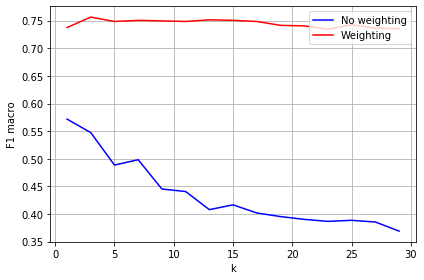

Grid search best params= {'n_neighbors': 3, 'weights': 'distance'} F1 macro= 0.581386317792844


In [15]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [16]:
pred = accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)
print_confusion_matrix(pred)
print_scores(pred)

[[ 12  23   0   0   0]
 [  8 250  17   1   0]
 [  1  30  49   8   0]
 [  0   1  15   8   1]
 [  0   0   3   4   1]]
F1 macro: 0.48164678458113136, Accuracy: 0.7407407407407407, Precision macro: 0.5716165413533835, Recall macro: 0.45009448522491996


As we can see it clearly recognizes the second level but not the others. The level 3 and 4 are especially quite wrong.

## 2.2. Only categorical features

In [17]:
# only categorical
X_train = train_data.select_dtypes(include=['object','bool'])
transform_categorical_to_numerical(X_train)
X_test = test_data.select_dtypes(include=['object','bool'])
transform_categorical_to_numerical(X_test)

### 10-fold cross-validation

In [18]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.43717172 0.35670386 0.68586299 0.33978654 0.25588235 0.37548517
 0.51212121 0.41149519 0.4258918  0.50253968]


In [19]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.430294051188526
0.11166076257382


### Find best parameters

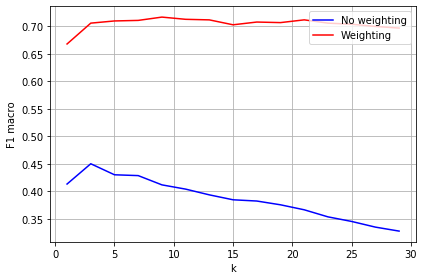

Grid search best params= {'n_neighbors': 3, 'weights': 'distance'} F1 macro= 0.45564851272320456


In [20]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [21]:
pred = accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)
print_confusion_matrix(pred)
print_scores(pred)

[[ 11  24   0   0   0]
 [ 16 227  30   3   0]
 [  2  37  43   5   1]
 [  0   5  12   4   4]
 [  0   1   3   2   2]]
F1 macro: 0.4201344927002822, Accuracy: 0.6643518518518519, Precision macro: 0.4422968246859872, Recall macro: 0.40707716920760395


Like in the previous one, it clearly recognizes the second level. However it misleads the 1st, 4th and 5th level.

## 2.3. Categorical and numerical features

In [22]:
X_train = train_data.copy()
transform_categorical_to_numerical(X_train)
X_test = test_data.copy()
transform_categorical_to_numerical(X_test)

### 10-fold cross-validation

In [23]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.45151936 0.35661187 0.69338875 0.33978654 0.4400707  0.51070501
 0.51551434 0.46825312 0.42184874 0.51461039]


In [24]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.4712308818662594
0.0943277409051791


### Find best parameters

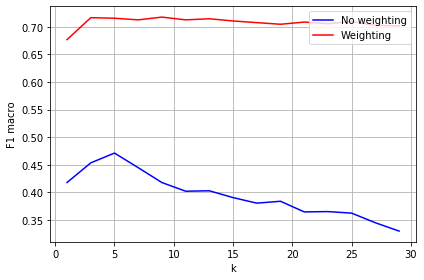

Grid search best params= {'n_neighbors': 5, 'weights': 'uniform'} F1 macro= 0.4712308818662594


In [25]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [26]:
pred = accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)
print_confusion_matrix(pred)
print_scores(pred)

[[  8  27   0   0   0]
 [ 11 243  22   0   0]
 [  0  40  45   3   0]
 [  0   6  12   5   2]
 [  0   2   3   2   1]]
F1 macro: 0.4222844693432929, Accuracy: 0.6990740740740741, Precision macro: 0.5134634792226771, Recall macro: 0.3890739695087521


It is pretty similar to the last one.

## 2.4. Only numerical features from PCA

In [27]:
X_train = train_pca_data.copy()
X_test = test_pca_data.copy()

### 10 cross-validation

In [28]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.66999349 0.34500829 0.47306373 0.47014493 0.42513381 0.67372627
 0.75794038 0.47197247 0.49056553 0.50272727]


In [29]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.5280276184781012
0.12242655860938408


### Find best parameters

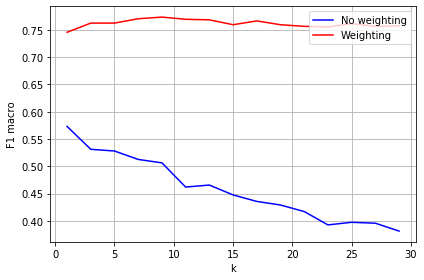

Grid search best params= {'n_neighbors': 9, 'weights': 'distance'} F1 macro= 0.5980861681126852


In [30]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [31]:
pred = accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)
print_confusion_matrix(pred)
print_scores(pred)

[[  9  26   0   0   0]
 [  7 255  14   0   0]
 [  0  26  53   8   1]
 [  0   0  10  15   0]
 [  0   0   3   3   2]]
F1 macro: 0.5621101613887408, Accuracy: 0.7731481481481481, Precision macro: 0.6598417272195773, Recall macro: 0.526665725578769


As we can see it's better than the prior ones, but it still has the same errors, especially in the 1st and last level.

## 2.5. Numerical features from PCA and categorical

In [32]:
cat_train = train_data.select_dtypes(include=['object','bool'])
cat_test = test_data.select_dtypes(include=['object','bool'])
transform_categorical_to_numerical(cat_train)
transform_categorical_to_numerical(cat_test)
cat_train['Id'] = id_train_data
cat_test['Id'] = id_test_data
X_train = train_pca_data.copy()
X_test = test_pca_data.copy()
X_train['Id'] = id_train_pca_data
X_test['Id'] = id_test_pca_data
X_train = pd.merge(X_train, cat_train, on='Id')
X_test = pd.merge(X_test, cat_test, on='Id')
X_train.drop(columns=['Id'],inplace=True)
X_test.drop(columns=['Id'],inplace=True)

### 10 cross-validation

In [33]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.45450443 0.35251591 0.69837188 0.33130981 0.44448441 0.51070501
 0.51678156 0.47555556 0.43388083 0.49492723]


In [34]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.471303660814108
0.09584758498345462


### Find best parameters

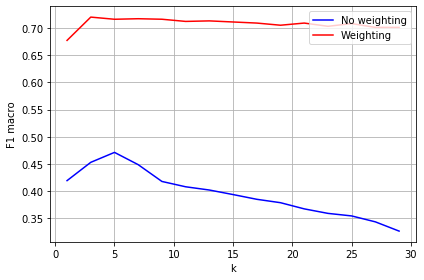

Grid search best params= {'n_neighbors': 5, 'weights': 'uniform'} F1 macro= 0.471303660814108


In [35]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [36]:
pred = accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)
print_confusion_matrix(pred)
print_scores(pred)

[[  8  27   0   0   0]
 [ 12 243  21   0   0]
 [  0  38  47   3   0]
 [  0   6  12   5   2]
 [  0   1   4   2   1]]
F1 macro: 0.42545764234584926, Accuracy: 0.7037037037037037, Precision macro: 0.5128571428571429, Recall macro: 0.39361942405420663


It is very similar to the previous ones.

# 3. Some modifications

In this section we are going to test some variations of the model which obtained the best accuracy in the last part, but with numerical features from PCA.

## 3.1. Balanced dataset

The feature to predict is very unbalanced, so we are gonna try to balance it in the training dataset and see if the accuracy increases.

In [37]:
X_train = train_pca_data.copy()
X_test = test_pca_data.copy()

In [38]:
aux = train_pca_data.copy()
aux['SalePrice'] = y_train

X1 = aux[aux['SalePrice'] == 'Level1']
X2 = aux[aux['SalePrice'] == 'Level2']
X3 = aux[aux['SalePrice'] == 'Level3']
X4 = aux[aux['SalePrice'] == 'Level4']
X5 = aux[aux['SalePrice'] == 'Level5']

train_pca_data_balanced = pd.DataFrame()

for i in range(3):
    train_pca_data_balanced = train_pca_data_balanced.append(X1, ignore_index = True)
train_pca_data_balanced = train_pca_data_balanced.append(X2.sample(frac=1/3), ignore_index = True)
train_pca_data_balanced = train_pca_data_balanced.append(X3, ignore_index = True)
for i in range(4):
    train_pca_data_balanced = train_pca_data_balanced.append(X4, ignore_index = True)
for i in range(12):
    train_pca_data_balanced = train_pca_data_balanced.append(X5, ignore_index = True)

train_pca_data_balanced['SalePrice'].value_counts()

Level1    237
Level4    236
Level3    223
Level2    209
Level5    204
Name: SalePrice, dtype: int64

In [39]:
y_train_balanced = train_pca_data_balanced['SalePrice']
train_pca_data_balanced.drop(columns=['SalePrice'],inplace=True)

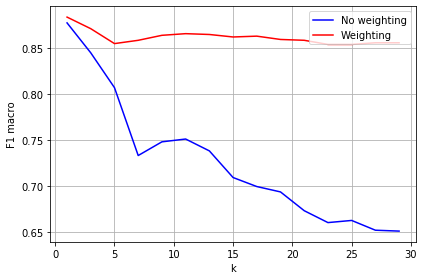

Grid search best params= {'n_neighbors': 9, 'weights': 'distance'} F1 macro= 0.5980861681126852


In [40]:
parval = find_best_params(train_pca_data_balanced,y_train_balanced)

In [41]:
train_pca_data_balanced.shape

(1109, 6)

In [42]:
y_train_balanced.shape

(1109,)

In [43]:
y_train_balanced.value_counts()

Level1    237
Level4    236
Level3    223
Level2    209
Level5    204
Name: SalePrice, dtype: int64

In [44]:
X_test.shape

(432, 6)

In [45]:
y_test.shape

(432,)

In [46]:
pred = accuracy_with_test_data(parval['n_neighbors'],parval['weights'],train_pca_data_balanced,y_train_balanced,X_test,y_test)
print_confusion_matrix(pred)
print_scores(pred)
print_classification_report(pred)

[[ 31   4   0   0   0]
 [ 70 170  33   3   0]
 [  0   6  66  15   1]
 [  0   0   3  19   3]
 [  0   0   1   3   4]]
F1 macro: 0.5954422498168143, Accuracy: 0.6712962962962963, Precision macro: 0.5734303673085756, Recall macro: 0.7023312629399585
              precision    recall  f1-score   support

      Level1       0.31      0.89      0.46        35
      Level2       0.94      0.62      0.75       276
      Level3       0.64      0.75      0.69        88
      Level4       0.47      0.76      0.58        25
      Level5       0.50      0.50      0.50         8

    accuracy                           0.67       432
   macro avg       0.57      0.70      0.60       432
weighted avg       0.80      0.67      0.70       432



We can see that the overall accuracy decreases but the different levels are more accurate than in the previous tests (with a higher f1 macro score).

Let's do a McNemar test to see if the results are statistically different than the model with the input not balanced.

In [47]:
# Numerical features from PCA with input not balanced
n_neighbors = 9 # best params found earlier
weights = 'distance' # best params found earlier
pred_not_balanced = accuracy_with_test_data(n_neighbors,weights,X_train,y_train,X_test,y_test)

res1=np.zeros(y_test.shape)
res1[pred==y_test]=1
res2=np.zeros(y_test.shape)
res2[pred_not_balanced==y_test]=1

# Build contingency matrix
n00 = np.sum([res1[res2==1]==1])
n11 = np.sum([res1[res2==0]==0])
n10 = np.sum([res1[res2==1]==0])
n01 = np.sum([res1[res2==0]==1])

# Chi -square test
print("Have the classifiers significant different accuracy?:",(np.abs(n01-n10)-1)**2/(n01+n10)>3.84)

Have the classifiers significant different accuracy?: True


So the classifier trained with balanced data it's better than the one who is not.

## 3.2. Change distance metric

Let's do a grid search and a chart to find what is the best distance metric. We are doing this test with the numerical features obtained from PCA.

In [48]:
X_train = train_pca_data_balanced.copy()
X_test = test_pca_data.copy()

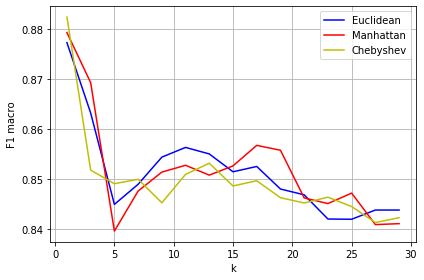

In [49]:
# Chart
lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance',metric='euclidean'), X=X_train, y=y_train_balanced, cv=10, scoring='f1_macro')
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'b',label='Euclidean')

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance',metric='manhattan'), X=X_train, y=y_train_balanced, cv=10, scoring='f1_macro')
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'r',label='Manhattan')

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance',metric='chebyshev'), X=X_train, y=y_train_balanced, cv=10, scoring='f1_macro')
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'y',label='Chebyshev')

plt.xlabel('k')
plt.ylabel('F1 macro')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

In [50]:
#Grid search
params = {'n_neighbors':list(range(1,30,2)), 'metric': ('euclidean','manhattan','chebyshev')}
knc = nb.KNeighborsClassifier(weights='distance')
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1,scoring='f1_macro')
clf.fit(X_train, y_train_balanced)
print("Grid search best params=",clf.best_params_, "F1 macro=", clf.best_score_)

Grid search best params= {'metric': 'chebyshev', 'n_neighbors': 1} F1 macro= 0.8824500335124931


Let's see the results with the test dataset

In [51]:
pred = accuracy_with_test_data(1,'distance',train_pca_data_balanced,y_train_balanced,X_test,y_test,'chebyshev')
print_confusion_matrix(pred)
print_scores(pred)

[[ 16  19   0   0   0]
 [ 40 201  33   2   0]
 [  0  11  65  11   1]
 [  0   0  12  12   1]
 [  0   0   4   0   4]]
F1 macro: 0.567908137559318, Accuracy: 0.6898148148148148, Precision macro: 0.5745372522214628, Recall macro: 0.5808080180688877


We can see it is not better than with the default distance metric.

# 4. How the amount of training data influences accuracy

In [52]:
X_train = train_pca_data_balanced.copy()
X_test = test_pca_data.copy()
n_neighbors = 9
weights = 'distance'

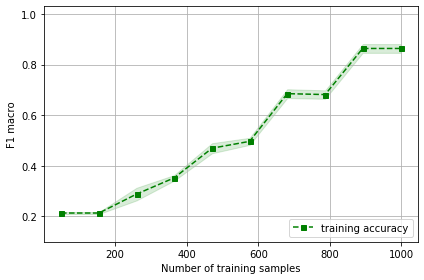

In [53]:
train_sizes, train_scores, test_scores =\
                sklearn.model_selection.learning_curve(estimator=nb.KNeighborsClassifier(n_neighbors,weights),
                               X=X_train,
                               y=y_train_balanced,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='training accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('F1 macro')
plt.legend(loc='lower right')
plt.ylim([0.1, 1.03])
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()

We can see a clearly a linear relation between the input samples and the quality of the classifier. It seems it gets stabilized around 900 samples but we don't have enough information to confirm it.

# 5. Comparison table 

The next table compares the results of all the previous tests

| Model | F1 macro | Accuracy | Precision macro | Recall macro |
|------|------|------|------|------|
| Only numerical features | 0.48 | 0.74 | 0.57 | 0.57 |
| Only categorical features | 0.42 | 0.66 | 0.44 | 0.44 |
| Numerical and categorical features | 0.42 | 0.7 | 0.51 | 0.51 |
| Only numerical features from PCA | 0.56 | 0.77 | 0.65 | 0.66 |
| Numerical features from PCA and categorical | 0.43 | 0.7 | 0.51 | 0.51 |
| Balanced dataset with only the numerical features from PCA | 0.59 | 0.68 | 0.57 | 0.57 |

As we can see the model with the higher f1 score is the one obtained only with the numerical features from PCA in a balanced dataset. We should take into account that the model with the higher accuracy is the one with an unbalanced dataset.

# 6. Best result analysis

Let's show the different scores for the model with only the numerical features from PCA.

In [54]:
X_train = train_pca_data_balanced.copy()
X_test = test_pca_data.copy()
n_neighbors = 9
weights = 'distance'
pred = accuracy_with_test_data(n_neighbors,weights,X_train,y_train_balanced,X_test,y_test)
print_classification_report(pred)

              precision    recall  f1-score   support

      Level1       0.31      0.89      0.46        35
      Level2       0.94      0.62      0.75       276
      Level3       0.64      0.75      0.69        88
      Level4       0.47      0.76      0.58        25
      Level5       0.50      0.50      0.50         8

    accuracy                           0.67       432
   macro avg       0.57      0.70      0.60       432
weighted avg       0.80      0.67      0.70       432



- Level1: Almost all the elements of the level 1 are predicted as level 1 but only 34% of the elements of Level1 are correctly predicted.
- Level2: This is the one with the best precision and f1 score.
- Level3: It has very similar precision and recall scores.
- Level4: It has a low precision but a good recall.
- Level5: The results are not very good, it has 0.5 as precision and 0.5 as recall.

Let's compute the interval of confidence.

In [55]:
epsilon = sklearn.metrics.f1_score(y_test, pred, average='macro')
print("Confidence interval: ",proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test'))

Confidence interval:  (0.547487587741526, 0.6413153646843415)
